In [2]:
# --- Install Required Packages ---
!pip install scikit-optimize
!pip install tqdm_joblib
!pip install umap-learn
!pip install PyWavelets

# --- Standard Library Imports ---
import os
import random
import re
import warnings
import multiprocessing
from pathlib import Path

# --- Google Colab / IPython Imports ---
from google.colab import drive
from IPython.display import Image

# --- Third-Party Library Imports ---
import cv2
import cupy as cp
import cuml
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
import seaborn as sns
import torch
import logging
import umap
from joblib import Parallel, delayed
from scipy.stats import kurtosis, skew
from skimage import exposure
from skimage.color import rgb2gray
from skimage.feature import (
    hog, local_binary_pattern, graycomatrix, graycoprops
)
from skimage.filters import sobel
from skimage.measure import shannon_entropy
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from transformers import (
    ViTModel, ViTImageProcessor, ViTFeatureExtractor
)

# --- CuML Imports ---
from cuml.pipeline import Pipeline as cuPipeline
from cuml.preprocessing import StandardScaler as cuStandardScaler
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.linear_model import LogisticRegression as cuLogReg
from cuml.model_selection import StratifiedKFold as cuStratifiedKFold
from cuml.neighbors import KNeighborsClassifier as cuKNeighbors
from cuml.svm import SVC as cuSVC

# --- Imbalanced-Learn Imports ---
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# --- Scikit-Optimize Imports ---
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real

# --- Scikit-Learn Imports ---
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, classification_report,
    confusion_matrix, roc_auc_score, f1_score
)
from sklearn.model_selection import (
    GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

# --- XGBoost Imports ---
from xgboost import XGBClassifier

# --- Configuration ---
random.seed(42)
warnings.filterwarnings("ignore")

# Get the logger used by the cuml library and set its level
logging.getLogger('cuml').setLevel(logging.ERROR)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.8 MB/s eta 0:00:00


In [3]:
base_dir = Path('/content/skin-cancer-mnist-ham10000')
zip_file = Path('skin-cancer-mnist-ham10000.zip')

# Download zip file from Drive if file doesn't exist
if not zip_file.exists():
    !gdown https://drive.google.com/file/d/1wS-ExXzOFyF8evYLi6kNhhFkF0-uFBxq/view?usp=sharing --fuzzy
else:
    print("ZIP file already exists, skipping download.")

# Unzip if data folder doesn't exist
if not base_dir.exists():
    !unzip skin-cancer-mnist-ham10000.zip
else:
    print("Data directory already exists, skipping extraction.")

Streaming output truncated to the last 5000 lines.
  inflating: skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0030125.jpg  
  inflating: skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0032732.jpg  
  inflating: skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0033438.jpg  
  inflating: skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0032726.jpg  
  inflating: skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0029460.jpg  
  inflating: skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0030131.jpg  
  inflating: skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0030657.jpg  
  inflating: skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0029306.jpg  
  inflating: skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0031549.jpg  
  inflating: skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0032040.jpg  
  inflating: skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0031561.jpg  
  inflating: skin-cancer-mnist-ham10000/HAM1000

# EDA (TODO)

## Visualization & EDA Helper Functions

In [ ]:
def whoAmI(img):
    """
    Prints dtype, min, max, mean, height, and width of an image.
    """
    print(f"dtype     : {img.dtype}")
    print(f"min       : {np.min(img):.4f}")
    print(f"max       : {np.max(img):.4f}")
    print(f"mean      : {np.mean(img):.4f}")
    print(f"shape     : {img.shape}")
    if img.ndim == 2:
        print(f"height    : {img.shape[0]}")
        print(f"width     : {img.shape[1]}")
    elif img.ndim == 3:
        print(f"height    : {img.shape[0]}")
        print(f"width     : {img.shape[1]}")
        print(f"channels  : {img.shape[2]}")

#VS - II helpful functions

# summarizes a data frame in a printer friendly way
def summarize_dataframe(df):
    summary = pd.DataFrame({
        'Column Name': df.columns,
        'Data Type': df.dtypes.values,
        'Null Count': df.isnull().sum().values,
        'Non-Null Count': df.notnull().sum().values,
        'Unique Count': df.nunique().values
    })
    return summary

def plot_training_history(history):
    """
    Plots training and validation loss & accuracy from a Keras history object.

    Parameters:
    - history: Keras history object from model.fit()
    """

    epochs = range(1, len(history.history['loss']) + 1)

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']


    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(epochs, train_loss, label='Training Loss', color='blue', linestyle='-')
    ax[0].plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, train_acc, label='Training Accuracy', color='blue', linestyle='-')
    ax[1].plot(epochs, val_acc, label='Validation Accuracy', color='red', linestyle='--')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()



# Preprocessing Helper Functions

In [4]:
# ---------------------- Hair Removal ----------------------
def remove_hairs(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, thresh = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    result = cv2.inpaint(img, thresh, inpaintRadius=1, flags=cv2.INPAINT_TELEA)
    return result


# ---------------------- Scale Marker Masking ----------------------
def mask_scale_markers(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h > 500 and (w/h > 5 or h/w > 5):
            img[y:y+h, x:x+w] = 0
    return img


# ---------------------- Combined Preprocessing ----------------------
def preprocess_image(img):
    img_no_hair = remove_hairs(img)
    img_clean = mask_scale_markers(img_no_hair)
    return img_clean

# ---------------------- Worker Parallelization Function  ----------------------
def process_single_image_entry(image_path, label, image_id, resize_shape):
    """
    Worker function to load, preprocess, and resize a single image.
    Returns a tuple of (image, label, image_id).
    """
    if os.path.exists(image_path):
        # Load and convert image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Apply your existing preprocessing steps
        img = preprocess_image(img) # This calls remove_hairs and mask_scale_markers

        # Resize
        img = cv2.resize(img, resize_shape)
        return img, label, image_id

    # Return None if the file path is invalid
    return None, None, None

# ---------------------- Master Parallelization Function  ----------------------
def preprocess_all_images_parallel(df, resize_shape=(224, 224)):
    """
    Preprocesses all images from the DataFrame in parallel with a progress bar.
    """
    # Use the tqdm_joblib context manager for a clean progress bar
    with tqdm_joblib(desc="Preprocessing Images", total=len(df)) as progress_bar:
        results = Parallel(n_jobs=-1, verbose=0)(
            delayed(process_single_image_entry)(
                row['path'], row['dx'], row['image_id'], resize_shape
            )
            for _, row in df.iterrows()
        )

    # Filter out any failed results (where the image path was invalid)
    valid_results = [res for res in results if res[0] is not None]

    # Unzip the list of tuples into separate lists
    images, labels, image_ids = zip(*valid_results)

    return np.array(images), list(labels), list(image_ids)

# Feature Extraction Helper Functions

## Simple Feature Extraction

In [ ]:
# HSV Features
def compute_hsv_histogram(img, h_bins=16, s_bins=8, v_bins=8):
    """
    Compute a normalized HSV color histogram from an RGB image.

    Args:
        img (np.ndarray): RGB image.
        h_bins, s_bins, v_bins: Number of bins for H, S, and V channels.

    Returns:
        np.ndarray: Flattened and normalized HSV histogram.
    """
    # Convert from RGB to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Compute 3D histogram
    hist = cv2.calcHist(
        [hsv], [0, 1, 2], None,
        [h_bins, s_bins, v_bins],
        [0, 180, 0, 256, 0, 256]
    )

    # Normalize and flatten
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_hsv_features_from_array(image_array, bins=(16, 8, 8)):
    h_bins, s_bins, v_bins = bins
    with tqdm_joblib(desc="Extracting HSV Features", total=len(image_array)) as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_hsv_histogram)(img, h_bins, s_bins, v_bins) for img in image_array
        )
    return np.array(features)

In [ ]:
# HoG Features
def compute_hog(img):
    gray_img = rgb2gray(img)
    features = hog(
        gray_img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False
    )
    return features

def extract_hog_features_from_array(image_array):
    with tqdm_joblib(desc="Extracting HOG Features", total=len(image_array)) as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_hog)(img) for img in image_array
        )
    return np.array(features)

In [ ]:
# LBP Features
def compute_lbp_features(img, radius=1, n_points=8, method='uniform'):
    """
    Compute a normalized LBP histogram from a grayscale version of the RGB image.

    Args:
        img (np.ndarray): RGB image.
        radius (int): Radius of circle.
        n_points (int): Number of sampling points.
        method (str): LBP method ('uniform', 'default', etc.).

    Returns:
        np.ndarray: Normalized LBP histogram (1D feature vector).
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, n_points, radius, method=method)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist




def extract_lbp_features_from_array(image_array, radius=1, n_points=8, method='uniform'):
    with tqdm_joblib(desc="Extracting LBP Features", total=len(image_array)) as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_lbp_features)(img, radius, n_points, method) for img in image_array
        )
    return np.array(features)

In [ ]:
# Sobel Edge Mean Features
def compute_sobel_features(img):
    """
    Computes descriptive statistics from the Sobel gradient magnitude.

    This more descriptive version includes measures of central tendency,
    dispersion, and shape of the gradient magnitude distribution.

    Args:
        img (np.ndarray): The input RGB image.

    Returns:
        np.ndarray: A 1D feature vector containing:
                    - mean
                    - standard deviation
                    - skewness
                    - kurtosis
                    - entropy
                    - 25th percentile
                    - median (50th percentile)
                    - 75th percentile
    """
    # 1. Convert to grayscale for edge detection
    gray = rgb2gray(img)

    # 2. Apply the Sobel filter to get the gradient magnitude
    sobel_magnitude = sobel(gray)

    # 3. Flatten the 2D magnitude image to a 1D array for most stats
    flat_magnitude = sobel_magnitude.flatten()

    # 4. Compute descriptive statistics
    features = [
        np.mean(flat_magnitude),
        np.std(flat_magnitude),
        skew(flat_magnitude),
        kurtosis(flat_magnitude),
        shannon_entropy(sobel_magnitude), # Entropy works on the 2D image
        np.percentile(flat_magnitude, 25),
        np.median(flat_magnitude),
        np.percentile(flat_magnitude, 75)
    ]
    return np.array(features)


# --- Parallel Extraction Function (No changes needed) ---
def extract_sobel_features_from_array(image_array):
    """Extracts Sobel features from an array of images in parallel."""
    # This function does not need to be changed.
    features = Parallel(n_jobs=-1, verbose=0)(
        delayed(compute_sobel_features)(img) for img in image_array
    )
    return np.array(features)

In [ ]:
# Wavelet features (using Haar)
def compute_wavelet_features(img):
    """
    Computes wavelet features using the Haar transform.

    Args:
        img (np.ndarray): RGB image.

    Returns:
        np.ndarray: A 1D feature vector containing mean of approximation
                    coefficients and energy of detail coefficients.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Resize to an even dimension if necessary for wavelet transform
    height, width = gray.shape
    if height % 2 != 0 or width % 2 != 0:
        gray = cv2.resize(gray, (width - width % 2, height - height % 2))

    cA, (cH, cV, cD) = pywt.dwt2(gray, 'haar')
    wavelet_features = [
        np.mean(cA),
        np.sum(cH**2),
        np.sum(cV**2),
        np.sum(cD**2)
    ]
    return np.array(wavelet_features)


def extract_wavelet_features_from_array(image_array):
    """Extracts wavelet features from an array of images in parallel."""
    with tqdm_joblib(total=len(image_array), desc="Extracting Wavelet Features") as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_wavelet_features)(img) for img in image_array
        )
    return np.array(features)

In [ ]:
# Color Features
def compute_color_features(img, hist_bins=(8, 8, 8)):
    """
    Computes color statistics (mean, std) and a normalized color histogram.

    Args:
        img (np.ndarray): RGB image.
        hist_bins (tuple): Number of bins for R, G, and B channels.

    Returns:
        np.ndarray: A concatenated 1D feature vector containing
                    mean RGB, std dev RGB, and the flattened normalized histogram.
    """
    # 1. Color Statistics
    mean_rgb = img.mean(axis=(0, 1))
    std_rgb = img.std(axis=(0, 1))

    # 2. Color Histogram
    hist = cv2.calcHist(
        [img], [0, 1, 2], None, hist_bins,
        [0, 256, 0, 256, 0, 256]
    )

    # Normalize and flatten
    hist = cv2.normalize(hist, hist).flatten()

    return np.concatenate([mean_rgb, std_rgb, hist])

def extract_color_features_from_array(image_array, hist_bins=(8, 8, 8)):
    """Extracts color features from an array of images in parallel."""
    with tqdm_joblib(total=len(image_array), desc="Extracting Color Features") as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_color_features)(img, hist_bins) for img in image_array
        )
    return np.array(features)


In [ ]:
# Statistical features
def compute_intensity_stats(img):
    """
    Computes statistical moments of the pixel intensities.

    Args:
        img (np.ndarray): RGB image.

    Returns:
        np.ndarray: A 1D feature vector containing mean, standard deviation,
                    skewness, and kurtosis of the grayscale image.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    pixels = gray.flatten()

    features = [
        np.mean(pixels),
        np.std(pixels),
        skew(pixels),
        kurtosis(pixels)
    ]
    return np.array(features)


def extract_intensity_stats_from_array(image_array):
    """Extracts intensity statistics from an array of images in parallel."""
    with tqdm_joblib(total=len(image_array), desc="Extracting Intensity Stats") as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_intensity_stats)(img) for img in image_array
        )
    return np.array(features)


In [ ]:
# GLCM Features
def compute_glcm_features(img, distances=[5], angles=[0]):
    """
    Computes texture features using a Gray-Level Co-occurrence Matrix (GLCM).

    Args:
        img (np.ndarray): RGB image.
        distances (list): List of pixel pair distance offsets.
        angles (list): List of pixel pair angles in radians.

    Returns:
        np.ndarray: A 1D feature vector containing contrast, dissimilarity,
                    homogeneity, ASM, energy, and correlation.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    glcm = graycomatrix(
        gray, distances=distances, angles=angles,
        levels=256, symmetric=True, normed=True
    )

    props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    features = [graycoprops(glcm, prop)[0, 0] for prop in props]

    return np.array(features)

def extract_glcm_features_from_array(image_array, distances=[5], angles=[0]):
    """Extracts GLCM features from an array of images in parallel."""
    with tqdm_joblib(total=len(image_array), desc="Extracting GLCM Features") as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_glcm_features)(img, distances, angles) for img in image_array
        )
    return np.array(features)


In [ ]:
# Gabor Features
def compute_gabor_features(img, resize_dim=(224, 224), orientations=6, scales=(1, 3, 5, 7)):
    """
    Computes features using a bank of Gabor filters.

    Args:
        img (np.ndarray): RGB image.
        resize_dim (tuple): Dimensions to resize the image to. Set to None to skip.
        orientations (int): Number of filter orientations.
        scales (tuple): A tuple of sigma values for the Gabor kernels.

    Returns:
        np.ndarray: A 1D vector containing the mean and std dev of each filtered response.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    if resize_dim:
        gray = cv2.resize(gray, resize_dim)

    features = []
    thetas = np.linspace(0, np.pi, orientations, endpoint=False)

    for theta in thetas:
        for sigma in scales:
            kernel = cv2.getGaborKernel(
                ksize=(21, 21), sigma=sigma, theta=theta,
                lambd=10.0, gamma=0.5, psi=0, ktype=cv2.CV_32F
            )
            filtered = cv2.filter2D(gray, ddepth=-1, kernel=kernel)
            features.extend([filtered.mean(), filtered.std()])

    return np.array(features)


def extract_gabor_features_from_array(image_array, resize_dim=(224, 224), orientations=6, scales=(1, 3, 5, 7)):
    """Extracts Gabor features from an array of images in parallel."""
    with tqdm_joblib(total=len(image_array), desc="Extracting Gabor Features") as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_gabor_features)(img, resize_dim, orientations, scales) for img in image_array
        )
    return np.array(features)

In [ ]:
# Shape Features
def compute_shape_features(img):
    """
    Computes shape features from the largest contour in the image.

    Args:
        img (np.ndarray): RGB image.

    Returns:
        np.ndarray: A 1D vector of [area, perimeter, compactness].
                    Returns zeros if no contours are found.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return np.zeros(3)

    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)

    if area == 0:
        return np.zeros(3)

    compactness = (perimeter ** 2) / (4 * np.pi * area)

    return np.array([area, perimeter, compactness])

def extract_shape_features_from_array(image_array):
    """Extracts shape features from an array of images in parallel."""
    with tqdm_joblib(total=len(image_array), desc="Extracting Shape Features") as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_shape_features)(img) for img in image_array
        )
    return np.array(features)

In [ ]:
# Corner Features
def compute_corner_features(img, max_corners=100, quality_level=0.01, min_distance=10):
    """
    Computes the number of corners detected by the Shi-Tomasi method.

    Args:
        img (np.ndarray): RGB image.
        max_corners (int): Maximum number of corners to return.
        quality_level (float): Parameter for corner detection (0-1).
        min_distance (int): Minimum Euclidean distance between corners.

    Returns:
        np.ndarray: A 1D array with a single feature: the corner count.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    corners = cv2.goodFeaturesToTrack(
        gray, maxCorners=max_corners,
        qualityLevel=quality_level,
        minDistance=min_distance
    )

    num_corners = 0 if corners is None else len(corners)
    return np.array([num_corners])

def extract_corner_features_from_array(image_array, max_corners=100, quality_level=0.01, min_distance=10):
    """Extracts corner features from an array of images in parallel."""
    with tqdm_joblib(total=len(image_array), desc="Extracting Corner Features") as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_corner_features)(img, max_corners, quality_level, min_distance) for img in image_array
        )
    return np.array(features)

In [ ]:
# SIFT Features
def compute_sift_features(img, max_features=50):
    """
    Computes SIFT features and returns a fixed-size vector by padding/truncating.

    Args:
        img (np.ndarray): RGB image.
        max_features (int): The target number of descriptors.

    Returns:
        np.ndarray: A flattened 1D feature vector of size (max_features * 128).
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute(gray, None)

    if descriptors is None:
        return np.zeros(max_features * 128)

    num_descriptors = descriptors.shape[0]
    if num_descriptors < max_features:
        pad_width = max_features - num_descriptors
        # Pad with zeros to reach max_features
        feature_vec = np.pad(descriptors, ((0, pad_width), (0, 0)), 'constant')
    else:
        # Truncate to keep only the first max_features
        feature_vec = descriptors[:max_features, :]

    return feature_vec.flatten()

def extract_sift_features_from_array(image_array, max_features=50):
    """Extracts fixed-size SIFT features from an array of images in parallel."""
    with tqdm_joblib(total=len(image_array), desc="Extracting SIFT Features") as progress_bar:
        features = Parallel(n_jobs=-1, verbose=0)(
            delayed(compute_sift_features)(img, max_features) for img in image_array
        )
    return np.array(features)

## Complex Feature Extraction

In [ ]:
def extract_vit_features_from_array(image_array, model, feature_processor, batch_size=32):
    """
    Extracts ViT [CLS] token embeddings from an array of RGB images using batch processing.

    Args:
        image_array (np.ndarray or list): A list or array of RGB images (H, W, C).
        model (torch.nn.Module): The pre-trained Vision Transformer model.
        feature_processor (ViTImageProcessor): The processor to prepare images for the model.
        batch_size (int): The number of images to process in a single batch.

    Returns:
        np.ndarray: A 2D array where each row is the [CLS] embedding for an image.
    """
    # Determine the device and move the model to it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    all_features = []
    num_images = len(image_array)

    # Process images in batches
    with tqdm_joblib(total=num_images, desc="Extracting ViT Features (Batching)") as pbar:
        for i in range(0, num_images, batch_size):
            # Create a batch of images
            batch_images = image_array[i:i + batch_size]

            # The feature processor expects a list of images
            inputs = feature_processor(images=list(batch_images), return_tensors="pt").to(device)

            # Perform inference without calculating gradients
            with torch.no_grad():
                outputs = model(**inputs)

            # Extract the [CLS] token's embeddings
            # The [CLS] token is always the first one
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_features.append(cls_embeddings)

            pbar.update(len(batch_images))

    # Concatenate all batch results into a single NumPy array
    return np.vstack(all_features)


# Model Selection & Configuration

In [17]:
MODELS = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'model__n_estimators': Integer(50, 500),
            'model__max_depth': Integer(5, 50),
            'model__min_samples_split': Integer(2, 12),
            'model__min_samples_leaf': Integer(1, 10),
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
        'params': {
            'model__n_estimators': Integer(50, 500),
            'model__max_depth': Integer(3, 15),
            'model__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
            'model__subsample': Real(0.6, 1.0),
            'model__colsample_bytree': Real(0.6, 1.0),
        }
    },
    'SVC': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'model__C': Real(1e-3, 1e3, prior='log-uniform'),
            'model__gamma': Real(1e-4, 1e-1, prior='log-uniform'),
            'model__kernel': Categorical(['rbf', 'poly']),
        }
    },
    'KNeighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': Integer(3, 30),
            'model__weights': Categorical(['uniform', 'distance']),
            'model__p': Integer(1, 2) # 1 for Manhattan, 2 for Euclidean
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=1000, solver='liblinear'),
        'params': {
            'model__penalty': Categorical(['l1', 'l2']),
            'model__C': Real(1e-3, 1e3, prior='log-uniform'),
        }
    }
}

In [25]:
MODELS_CUML = {
    'RandomForest_GPU': {
        'model': cuRF(random_state=42),
        'params': {
            'model__n_estimators': Integer(50, 500),
            'model__max_depth': Integer(5, 50),
            'model__n_bins': Integer(8, 128),
        }
    },
    'RandomForest_GPU_Balanced': {
        'model': cuRF(random_state=42),
        'params': {
            'n_estimators': Integer(50, 500),
            'max_depth': Integer(5, 50),
            'n_bins': Integer(8, 128),
        }
    },
    'XGBoost_GPU': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False,
                               eval_metric='mlogloss', tree_method='gpu_hist'),
        'params': {
            'model__n_estimators': Integer(50, 500),
            'model__max_depth': Integer(3, 15),
            'model__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        }
    },
    'XGBoost_GPU_Balanced': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False,
                               eval_metric='mlogloss', tree_method='gpu_hist'),
        'params': {
            'n_estimators': Integer(50, 500),
            'max_depth': Integer(3, 15),
            'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        }
    },
    'SVC_GPU': {
        'model': cuSVC(random_state=42, probability=True),
        'params': {
            'model__C': Real(1e-3, 1e3, prior='log-uniform'),
            'model__gamma': Real(1e-4, 1e-1, prior='log-uniform'),
        }
    },
    'SVC_GPU_Balanced': {
        'model': cuSVC(random_state=42, probability=True, class_weight='balanced'),
        'params': {
            'C': Real(1e-3, 1e3, prior='log-uniform'),
            'gamma': Real(1e-4, 1e-1, prior='log-uniform'),
        }
    },
    'KNeighbors_GPU': {
        'model': cuKNeighbors(),
        'params': {
            'model__n_neighbors': Integer(3, 30),
            'model__p': Integer(1, 2)
        }
    },
    'KNeighbors_GPU_Balanced': {
        'model': cuKNeighbors(),
        'params': {
            'n_neighbors': Integer(3, 30),
            'p': Integer(1, 2)
        }
    },
    'LogisticRegression_GPU': {
        'model': cuLogReg(max_iter=10000),
        'params': {
            'model__penalty': Categorical(['l1', 'l2']),
            'model__C': Real(1e-3, 1e3, prior='log-uniform'),
        }
    },
    'LogisticRegression_GPU_Balanced': {
        'model': cuLogReg(max_iter=10000),
        'params': {
            'penalty': Categorical(['l1', 'l2']),
            'C': Real(1e-3, 1e3, prior='log-uniform'),
        }
    }
}

[2025-07-25 02:17:19.447] [CUML] [warning] Random state is currently ignored by probabilistic SVC
[2025-07-25 02:17:19.448] [CUML] [warning] Random state is currently ignored by probabilistic SVC


# Hyperparameter Search & Model Evaluation

In [4]:
def run_auc_roc_gpu_evaluation_with_per_fold_sampling(model_name, X, y, n_splits=5, random_state=42):
    """
    Runs a GPU-accelerated pipeline for a single specified model.

    This function preserves the per-fold oversampling strategy and is designed
    for iterative execution in environments like Jupyter notebooks.

    Args:
        model_name (str): The name of the model to evaluate. Must be a key
                          in the global MODELS_CUML dictionary.
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target labels.
        n_splits (int): Number of folds for cross-validation.
        random_state (int): Seed for reproducibility.

    Returns:
        dict: A dictionary containing the results for the specified model,
              keyed by the model's name.
    """
    # Check if the requested model exists in the configuration dictionary
    if model_name not in MODELS_CUML:
        raise ValueError(f"Model '{model_name}' not found. Available models are: {list(MODELS_CUML.keys())}")

    # Get the configuration for the specified model
    config = MODELS_CUML[model_name]

    # Step 1: Stratified Train-Test Split (remains on CPU)
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

    # Split the full training set again into a smaller training set and a validation set for threshold tuning
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.25, stratify=y_train_full, random_state=random_state # 0.25 * 0.8 = 0.2
    )

    print(f"--- Starting Evaluation for: {model_name} ---")

    # Step 2: Create a pipeline that first oversamples (CPU), then fits the model (GPU)
    pipeline = ImbPipeline([
        ('sampler', RandomOverSampler(sampling_strategy='not majority', random_state=random_state)),
        ('model', config['model'])
    ])

    # Step 3: Set up cross-validation and hyperparameter search
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=config['params'],
        n_iter=25,
        cv=cv,
        scoring='roc_auc_ovr',
        n_jobs=1,  # Parallelism is on the GPU
        random_state=random_state,
        verbose=1
    )

    # Step 4: Run the Bayesian search
    print("Running Bayesian search (with per-fold CPU-GPU data transfer)...")
    bayes_search.fit(X_train, y_train)

    # Step 5: Find the best thresholds for prediction
    best_model = bayes_search.best_estimator_
    y_val_pred_proba = best_model.predict_proba(X_val)

    print("Finding optimal thresholds on validation set...")
    thresholds = []
    # Iterate over each class
    for i in range(y_val_pred_proba.shape[1]):
        best_f1 = 0
        best_thresh = 0.5 # Default threshold
        # Iterate over a range of potential thresholds
        for thresh in np.arange(0.01, 1.0, 0.01):
            # Apply threshold to get binary predictions for the current class
            y_pred_binary = (y_val_pred_proba[:, i] >= thresh).astype(int)
            # Binarize the true labels for the current class
            y_true_binary = (y_val == i).astype(int)

            f1 = f1_score(y_true_binary, y_pred_binary)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
        thresholds.append(best_thresh)

    print(f"Optimal thresholds found: {np.round(thresholds, 2)}")

    # Step 5: Evaluate using custom thresholds on the hold-out test set
    print("Evaluating best model on the hold-out test set with custom thresholds...")

    # Get probabilities on the test set
    y_test_pred_proba = best_model.predict_proba(X_test)

    # Apply custom thresholds to get final predictions
    final_predictions = []
    for probs in y_test_pred_proba:
        # Find which classes meet their threshold
        passed_threshold_indices = [i for i, prob in enumerate(probs) if prob >= thresholds[i]]

        if len(passed_threshold_indices) == 0:
            # If no class passes its threshold, fall back to the highest probability
            final_predictions.append(np.argmax(probs))
        else:
            # If one or more classes pass, predict the one with the highest probability among them
            best_class = -1
            max_prob = -1
            for idx in passed_threshold_indices:
                if probs[idx] > max_prob:
                    max_prob = probs[idx]
                    best_class = idx
            final_predictions.append(best_class)

    # Try this next to improve performance
    # thresholds_arr = np.array(thresholds)

    # # Avoid division by zero if a threshold is 0
    # thresholds_arr[thresholds_arr == 0] = 1e-9

    # # Divide probabilities by their respective thresholds and find the class with the highest resulting score
    # y_test_pred = np.argmax(y_test_pred_proba / thresholds_arr, axis=1)
    y_test_pred = np.array(final_predictions)

    report_dict = classification_report(y_test, y_test_pred, output_dict=True)
    test_auc = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr', average='macro')

    test_metrics = {
        'roc_auc': roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr', average='macro'),
        'accuracy': accuracy_score(y_test, y_test_pred),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_test_pred),
        'precision_macro': report_dict['macro avg']['precision'],
        'recall_macro': report_dict['macro avg']['recall'],
        'f1_macro': report_dict['macro avg']['f1-score'],
        'precision_weighted': report_dict['weighted avg']['precision'],
        'recall_weighted': report_dict['weighted avg']['recall'],
        'f1_weighted': report_dict['weighted avg']['f1-score']
    }

    # Store results for the single model
    final_results = {
        'best_model': best_model,
        'test_set_report': pd.DataFrame(report_dict).transpose(),
        'test_set_metrics': test_metrics,
        'best_cv_roc_auc': bayes_search.best_score_,
        'test_set_roc_auc': test_auc,
        'best_params': bayes_search.best_params_
    }

    print(f"Best cross-validation AUC-ROC score: {bayes_search.best_score_:.4f}")
    print(f"Best hyperparameters: {bayes_search.best_params_}")
    print(f"Test Set AUC-ROC score: {test_auc:.4f}\n")
    print(f"Test set classification report:\n{pd.DataFrame(report_dict).transpose()}")

    # Return results in a dictionary keyed by model name for consistent structure
    return {model_name: final_results}

In [5]:
def run_auc_roc_gpu_evaluation_with_class_weights(model_name, X, y, n_splits=5, random_state=42):
    """
    Runs a GPU-accelerated evaluation for a single model using balanced class weights.

    This function expects the model to handle class imbalance internally via
    the `class_weight='balanced'` parameter, instead of using oversampling.

    Args:
        model_name (str): The name of the model to evaluate from MODELS_CUML. The model
                          should be instantiated with `class_weight='balanced'`.
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target labels.
        n_splits (int): Number of folds for cross-validation.
        random_state (int): Seed for reproducibility.

    Returns:
        dict: A dictionary containing the results for the specified model.
    """
    if model_name not in MODELS_CUML:
        raise ValueError(f"Model '{model_name}' not found. Available models are: {list(MODELS_CUML.keys())}")

    config = MODELS_CUML[model_name]

    # Step 1: Data splitting (remains the same)
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.25, stratify=y_train_full, random_state=random_state
    )

    print(f"--- Starting Evaluation for: {model_name} (using class weights) ---")

    # Step 2: Set up hyperparameter search directly on the model
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    bayes_search = BayesSearchCV(
        estimator=config['model'],
        search_spaces=config['params'],
        n_iter=2, # have to set this in order for SVC to complete
        cv=cv,
        scoring='roc_auc_ovr',
        n_jobs=1,
        random_state=random_state,
        verbose=1
    )

    # Step 3: Run the Bayesian search
    print("Running Bayesian search...")
    bayes_search.fit(X_train, y_train)

    # Step 4: Find optimal thresholds (remains the same)
    best_model = bayes_search.best_estimator_
    y_val_pred_proba = best_model.predict_proba(X_val)

    print("Finding optimal thresholds on validation set...")
    thresholds = []
    for i in range(y_val_pred_proba.shape[1]):
        best_f1 = 0
        best_thresh = 0.5
        for thresh in np.arange(0.01, 1.0, 0.01):
            y_pred_binary = (y_val_pred_proba[:, i] >= thresh).astype(int)
            y_true_binary = (y_val == i).astype(int)
            f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
        thresholds.append(best_thresh)
    print(f"Optimal thresholds found: {np.round(thresholds, 2)}")

    # Step 5: Evaluate on test set with custom thresholds (remains the same)
    print("Evaluating best model on the hold-out test set with custom thresholds...")
    y_test_pred_proba = best_model.predict_proba(X_test)

    final_predictions = []
    for probs in y_test_pred_proba:
        passed_threshold_indices = [i for i, prob in enumerate(probs) if prob >= thresholds[i]]
        if not passed_threshold_indices:
            final_predictions.append(np.argmax(probs))
        else:
            best_class = max(passed_threshold_indices, key=lambda idx: probs[idx])
            final_predictions.append(best_class)

    y_test_pred = np.array(final_predictions)

    # Final reporting
    report_dict = classification_report(y_test, y_test_pred, output_dict=True)
    test_auc = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr', average='macro')

    test_metrics = {
        'roc_auc': roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr', average='macro'),
        'accuracy': accuracy_score(y_test, y_test_pred),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_test_pred),
        'precision_macro': report_dict['macro avg']['precision'],
        'recall_macro': report_dict['macro avg']['recall'],
        'f1_macro': report_dict['macro avg']['f1-score'],
        'precision_weighted': report_dict['weighted avg']['precision'],
        'recall_weighted': report_dict['weighted avg']['recall'],
        'f1_weighted': report_dict['weighted avg']['f1-score']
    }

    final_results = {
        'best_model': best_model,
        'test_set_report': pd.DataFrame(report_dict).transpose(),
        'test_set_metrics': test_metrics,
        'best_cv_roc_auc': bayes_search.best_score_,
        'test_set_roc_auc': test_auc,
        'best_params': bayes_search.best_params_
    }

    print(f"Best cross-validation AUC-ROC score: {bayes_search.best_score_:.4f}")
    print(f"Best hyperparameters: {bayes_search.best_params_}")
    print(f"Test Set AUC-ROC score: {test_auc:.4f}\n")
    print(f"Test set classification report:\n{pd.DataFrame(report_dict).transpose()}")

    return {model_name: final_results}

In [6]:
def run_f1_gpu_evaluation_with_per_fold_sampling(model_name, X, y, n_splits=5, random_state=42):
    """
    Runs a GPU-accelerated pipeline for a single specified model,
    optimized directly for the 'f1_macro' score.

    This version changes the Bayesian search scoring to f1_macro and
    removes the subsequent manual threshold tuning step.

    Args:
        model_name (str): The name of the model to evaluate. Must be a key
                          in the global MODELS_CUML dictionary.
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target labels.
        n_splits (int): Number of folds for cross-validation.
        random_state (int): Seed for reproducibility.

    Returns:
        dict: A dictionary containing the results for the specified model,
              keyed by the model's name.
    """
    # Check if the requested model exists in the configuration dictionary
    if model_name not in MODELS_CUML:
        raise ValueError(
            f"Model '{model_name}' not found. Available models are: {list(MODELS_CUML.keys())}"
        )

    # Get the configuration for the specified model
    config = MODELS_CUML[model_name]

    # Step 1: Stratified Train-Test Split (remains on CPU)
    # We no longer need a separate validation set for thresholding
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    print(f"--- Starting F1-Optimized Evaluation for: {model_name} ---")

    # Step 2: Create a pipeline that first oversamples (CPU), then fits the model (GPU)
    pipeline = ImbPipeline(
        [
            ("sampler", RandomOverSampler(sampling_strategy="not majority", random_state=random_state)),
            ("model", config["model"]),
        ]
    )

    # Step 3: Set up cross-validation and hyperparameter search
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=config["params"],
        n_iter=25,
        cv=cv,
        scoring="f1_macro",  # Optimize directly for the desired metric
        n_jobs=1,  # Parallelism is on the GPU
        random_state=random_state,
        verbose=1,
    )

    # Step 4: Run the Bayesian search
    print("Running Bayesian search (optimizing for F1-score)...")
    bayes_search.fit(X_train, y_train)

    # Step 5: Evaluate the best model on the hold-out test set
    # The manual thresholding step is removed as it's no longer necessary.
    print("Evaluating best model on the hold-out test set...")
    best_model = bayes_search.best_estimator_

    # Get predictions using the model's default (0.5) threshold,
    # which the bayes_search has implicitly optimized for.
    y_test_pred = best_model.predict(X_test)
    y_test_pred_proba = best_model.predict_proba(X_test)

    # Generate the classification report and other metrics
    report_dict = classification_report(y_test, y_test_pred, output_dict=True)
    test_auc = roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro")

    test_metrics = {
        "roc_auc_macro": test_auc,
        "accuracy": accuracy_score(y_test, y_test_pred),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_test_pred),
        "precision_macro": report_dict["macro avg"]["precision"],
        "recall_macro": report_dict["macro avg"]["recall"],
        "f1_macro": report_dict["macro avg"]["f1-score"],
        "precision_weighted": report_dict["weighted avg"]["precision"],
        "recall_weighted": report_dict["weighted avg"]["recall"],
        "f1_weighted": report_dict["weighted avg"]["f1-score"],
    }

    # Store results for the single model
    final_results = {
        "best_model": best_model,
        "test_set_report": pd.DataFrame(report_dict).transpose(),
        "test_set_metrics": test_metrics,
        "best_cv_f1_macro": bayes_search.best_score_, #
        "test_set_roc_auc": test_auc,
        "best_params": bayes_search.best_params_,
    }

    print(f"\nBest cross-validation F1-Macro score: {bayes_search.best_score_:.4f}")
    print(f"Best hyperparameters: {bayes_search.best_params_}")
    print(f"Test Set AUC-ROC score: {test_auc:.4f}\n")
    print(f"Test set classification report:\n{pd.DataFrame(report_dict).transpose()}")

    # Return results in a dictionary keyed by model name for consistent structure
    return {model_name: final_results}

In [15]:
def run_f1_gpu_evaluation_with_class_weights(model_name, X, y, n_splits=5, random_state=42):
    """
    Runs a GPU-accelerated evaluation for a model, optimizing for f1_macro.

    This function expects the model to handle class imbalance internally via
    the `class_weight='balanced'` parameter.

    Args:
        model_name (str): The name of the model to evaluate from MODELS_CUML. The model
                          should be instantiated with `class_weight='balanced'`.
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target labels.
        n_splits (int): Number of folds for cross-validation.
        random_state (int): Seed for reproducibility.

    Returns:
        dict: A dictionary containing the results for the specified model.
    """
    if model_name not in MODELS_CUML:
        raise ValueError(f"Model '{model_name}' not found. Available models are: {list(MODELS_CUML.keys())}")

    config = MODELS_CUML[model_name]

    # Step 1: Simplified data splitting (no validation set needed)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    print(f"--- Starting Evaluation for: {model_name} (optimizing for f1_macro) ---")

    # Step 2: Set up hyperparameter search to optimize for f1_macro
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    bayes_search = BayesSearchCV(
        estimator=config['model'],
        search_spaces=config['params'],
        n_iter=10,
        cv=cv,
        scoring='f1_macro',  # Changed scoring metric
        n_jobs=1,
        random_state=random_state,
        verbose=1
    )

    # Step 3: Run the Bayesian search
    print("Running Bayesian search...")
    bayes_search.fit(X_train, y_train)

    # Step 4: Evaluate the best model on the hold-out test set
    print("Evaluating best model on the hold-out test set...")
    best_model = bayes_search.best_estimator_

    # Use standard .predict() since thresholding is removed
    y_test_pred = best_model.predict(X_test)
    y_test_pred_proba = best_model.predict_proba(X_test) # Still useful for AUC reporting

    # Step 5: Final reporting
    report_dict = classification_report(y_test, y_test_pred, output_dict=True)

    test_metrics = {
        'roc_auc': roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr', average='macro'),
        'accuracy': accuracy_score(y_test, y_test_pred),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_test_pred),
        'precision_macro': report_dict['macro avg']['precision'],
        'recall_macro': report_dict['macro avg']['recall'],
        'f1_macro': report_dict['macro avg']['f1-score'],
        'precision_weighted': report_dict['weighted avg']['precision'],
        'recall_weighted': report_dict['weighted avg']['recall'],
        'f1_weighted': report_dict['weighted avg']['f1-score']
    }

    final_results = {
        'best_model': best_model,
        'test_set_report': pd.DataFrame(report_dict).transpose(),
        'test_set_metrics': test_metrics,
        'best_cv_f1_macro': bayes_search.best_score_, # Updated key
        'best_params': bayes_search.best_params_
    }

    print(f"Best cross-validation F1-macro score: {bayes_search.best_score_:.4f}") # Updated print statement
    print(f"Best hyperparameters: {bayes_search.best_params_}")
    print(f"Test Set F1-macro score: {test_metrics['f1_macro']:.4f}\n")
    print(f"Test set classification report:\n{pd.DataFrame(report_dict).transpose()}")

    return {model_name: final_results}

# Pipeline Execution

## Load Images

In [6]:
base_dir = Path('/content/skin-cancer-mnist-ham10000/')
file_path = base_dir / 'HAM10000_metadata.csv'
df = pd.read_csv(file_path)

# --- Image Path Gathering ---
image_paths = {}
image_folders = ['HAM10000_images_part_1', 'HAM10000_images_part_2']
for folder in image_folders:
    folder_path = base_dir / folder
    for image_file in folder_path.glob('**/*.jpg'):
        image_id = image_file.stem
        image_paths[image_id] = str(image_file) # Store path as string for cv2

df['path'] = df['image_id'].map(image_paths.get)
df.dropna(inplace=True)

## Preprocess & Extract Features

In [7]:
# Preprocess images
processed_images, raw_labels, image_ids = preprocess_all_images_parallel(df)

Preprocessing Images:   0%|          | 0/9958 [00:00<?, ?it/s]

In [ ]:
# Save data before feature extraction (same split as in our k-folds cross validation)
# random_state = 42
# X_train_paths, X_test_paths, y_train_paths, y_test_paths = train_test_split(
#     df['path'], df['dx'], test_size=0.15, stratify=df['dx'], random_state=random_state
# )
# np.savez('final_unbalanced_data.npz', X_train=X_train_paths, y_train=y_train_paths, X_test=X_test_paths, y_test=y_test_paths)

In [ ]:
# Extract Simple Features
X_hog = extract_hog_features_from_array(processed_images)
X_hsv = extract_hsv_features_from_array(processed_images)
X_lbp = extract_lbp_features_from_array(processed_images)
X_color = extract_color_features_from_array(processed_images)
X_intensity = extract_intensity_stats_from_array(processed_images)
X_glcm = extract_glcm_features_from_array(processed_images)
X_gabor = extract_gabor_features_from_array(processed_images)
X_shape = extract_shape_features_from_array(processed_images)
X_corners = extract_corner_features_from_array(processed_images)
X_sift = extract_sift_features_from_array(processed_images)
X_wavelet = extract_wavelet_features_from_array(processed_images)
X_sobel = extract_sobel_features_from_array(processed_images)

Extracting HOG Features:   0%|          | 0/9958 [00:00<?, ?it/s]

Extracting HSV Features:   0%|          | 0/9958 [00:00<?, ?it/s]

Extracting LBP Features:   0%|          | 0/9958 [00:00<?, ?it/s]

Extracting Color Features:   0%|          | 0/9958 [00:00<?, ?it/s]

Extracting Intensity Stats:   0%|          | 0/9958 [00:00<?, ?it/s]

Extracting GLCM Features:   0%|          | 0/9958 [00:00<?, ?it/s]

Extracting Gabor Features:   0%|          | 0/9958 [00:00<?, ?it/s]

Extracting Shape Features:   0%|          | 0/9958 [00:00<?, ?it/s]

Extracting Corner Features:   0%|          | 0/9958 [00:00<?, ?it/s]

Extracting SIFT Features:   0%|          | 0/9958 [00:00<?, ?it/s]

Extracting Wavelet Features:   0%|          | 0/9958 [00:00<?, ?it/s]

In [ ]:
# Extract Complex Features
MODEL_NAME = 'google/vit-base-patch16-224-in21k'
vit_model = ViTModel.from_pretrained(MODEL_NAME) # Load in ViT model
vit_processor = ViTImageProcessor.from_pretrained(MODEL_NAME)

X_vit = extract_vit_features_from_array(
    image_array=processed_images,
    model=vit_model,
    feature_processor=vit_processor,
    batch_size=32
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Extracting ViT Features (Batching):   0%|          | 0/9958 [00:00<?, ?it/s]

In [ ]:
# Create a list of features
X_feature_sets = {
    "hog": X_hog,
    "hsv": X_hsv,
    "lbp": X_lbp,
    "color": X_color,
    "intensity": X_intensity,
    "glcm": X_glcm,
    "gabor": X_gabor,
    "shape": X_shape,
    "corners": X_corners,
    "sift": X_sift,
    "X_wavelet": X_wavelet,
    "sobel": X_sobel,
    "ViT": X_vit
}

In [11]:
# Encode Labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(raw_labels)
class_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
class_mapping

{0: np.str_('akiec'),
 1: np.str_('bcc'),
 2: np.str_('bkl'),
 3: np.str_('df'),
 4: np.str_('mel'),
 5: np.str_('nv'),
 6: np.str_('vasc')}

In [ ]:
# Feature Screening with RAPIDS and the same oversampling strategy
def get_per_class_auc_gpu(y_true, y_pred_proba, model_classes):
    """
    Computes the ROC AUC score for each class using the One-vs-Rest strategy.

    Args:
        y_true (cp.ndarray): True labels.
        y_pred_proba (cp.ndarray): Predicted probabilities from the model.
        model_classes (cp.ndarray): The .classes_ attribute from the fitted classifier,
                                    ensuring correct column mapping.

    Returns:
        dict: A dictionary mapping each class label to its AUC score.
    """
    class_auc_scores = {}

    # Iterate over the classes in the order the model learned them
    for i, current_class in enumerate(model_classes):
        # Create binary labels for the current class (One-vs-Rest)
        y_true_binary = (y_true == current_class).astype(cp.int32)

        # Get the predicted probabilities for the corresponding class column
        y_pred_binary = y_pred_proba[:, i]

        # AUC is defined only if both classes are present in y_true_binary
        if len(cp.unique(y_true_binary)) < 2:
            score = cp.nan  # Use NaN for undefined AUCs
        else:
            score = cuml.metrics.roc_auc_score(y_true_binary, y_pred_binary)

        # Use the integer class label as the key
        class_auc_scores[int(current_class)] = float(score)

    return class_auc_scores

def screen_features_gpu(feature_sets, y, class_names=None):
    """
    Evaluates feature sets with oversampling inside each CV fold on the GPU.
    """
    results_list = []

    # 1. Move labels to the GPU once
    y_gpu = cp.asarray(y)

    # 2. Define the GPU-native pipeline
    probe_model_gpu = cuml.pipeline.Pipeline([
        ('scaler', cuml.preprocessing.StandardScaler()),
        ('classifier', cuRF(n_estimators=100, max_depth=16, random_state=42))
    ])

    # 3. Define the cuML splitter
    n_splits = 5
    cv_splitter = cuml.model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    print("--- Starting GPU Feature Screening with RAPIDS cuML ---")
    for name, X in tqdm(feature_sets.items(), desc="Screening Features on GPU"):
        X_gpu = cp.asarray(X, dtype=cp.float32)
        fold_scores_list = []


        # 4. Manually loop through the cross-validation folds
        # We have to do this due to mimic our oversampling strategy within our folds
        for train_idx, val_idx in cv_splitter.split(X_gpu, y_gpu):
            X_train, X_val = X_gpu[train_idx], X_gpu[val_idx]
            y_train, y_val = y_gpu[train_idx], y_gpu[val_idx]

            unique_classes, counts = cp.unique(y_train, return_counts=True)
            n_majority = counts.max()

            X_resampled_list = [X_train]
            y_resampled_list = [y_train]

            for i, current_class in enumerate(unique_classes):
                if counts[i] < n_majority:
                    n_samples_to_generate = int(n_majority - counts[i])
                    minority_indices = cp.where(y_train == current_class)[0]
                    resampled_indices = cp.random.choice(
                        minority_indices,
                        size=n_samples_to_generate,
                        replace=True
                    )
                    X_resampled_list.append(X_train[resampled_indices])
                    y_resampled_list.append(y_train[resampled_indices])

            X_train_resampled = cp.concatenate(X_resampled_list, axis=0)
            y_train_resampled = cp.concatenate(y_resampled_list, axis=0)

            # Fit the model on the new, balanced training data
            probe_model_gpu.fit(X_train_resampled, y_train_resampled)

            # Predict on the original & unseen validation set
            y_pred_proba = probe_model_gpu.predict_proba(X_val)

            # Get the class order from the fitted model
            model_classes = probe_model_gpu.named_steps['classifier'].classes_

            # Call the get_per_class_auc_gpu function to get per-class scores
            per_class_scores = get_per_class_auc_gpu(y_val, y_pred_proba, model_classes)
            fold_scores_list.append(per_class_scores)


        # Aggregate dictionaries
        fold_df = pd.DataFrame(fold_scores_list)
        mean_per_class_scores = fold_df.mean(axis=0) # Average each class column

        # Store results for this feature set
        feature_results = mean_per_class_scores.to_dict()
        feature_results['feature_set'] = name
        # Compute the macro-average for overall ranking
        feature_results['mean_auc_roc'] = mean_per_class_scores.mean()
        results_list.append(feature_results)

    # Create the final leaderboard
    leaderboard = pd.DataFrame(results_list).set_index('feature_set')

    # Rename integer columns to descriptive names if provided
    if class_names:
        leaderboard = leaderboard.rename(columns=class_names)

    # Reorder columns for readability
    mean_col = 'mean_auc_roc'
    other_cols = [col for col in leaderboard.columns if col != mean_col]
    leaderboard = leaderboard[[mean_col] + sorted(other_cols)]

    return leaderboard.sort_values(by=mean_col, ascending=False)


In [ ]:
# Optional code to threshold based on % of captured variance rather than top_k features, OPTIONAL atm
def select_features_by_score_threshold(leaderboard, score_threshold=0.95, max_features=5):
    """
    Selects feature sets based on a cumulative score threshold from a leaderboard.

    Args:
        leaderboard (pd.DataFrame): DataFrame with feature set names as index and
                                    a 'mean_auc_roc' column, sorted descending.
        score_threshold (float): The cumulative portion of total predictive power
                                 to capture (e.g., 0.95 for 95%).
        max_features (int): The maximum number of feature sets to return, regardless
                            of the threshold.

    Returns:
        list: A list of the selected feature set names.
    """
    # Scores represent performance above random (AUC=0.5)
    # Clip at 0 to avoid issues if a score is somehow below 0.5
    scores = (leaderboard['mean_auc_roc'] - 0.5).clip(lower=0)

    # Handle the case where all features have no predictive power
    if scores.sum() == 0:
        print("Warning: No feature sets showed predictive power. Returning the top feature.")
        return leaderboard.index[:1].tolist()

    # Normalize scores to sum to 1
    normalized_scores = scores / scores.sum()

    # Calculate cumulative sum
    cumulative_scores = normalized_scores.cumsum()

    # Find the indices of features that meet the cumulative score threshold
    threshold_indices = np.where(cumulative_scores >= score_threshold)[0]

    # The number of features needed is the first index to cross the threshold + 1
    num_to_select = threshold_indices[0] + 1 if len(threshold_indices) > 0 else len(leaderboard)

    # Apply the hard limit (max_features)
    final_num_to_select = num_to_select
    if max_features != -1:
      final_num_to_select = min(num_to_select, max_features)


    selected_names = leaderboard.index[:final_num_to_select].tolist()

    print(f"Selected {len(selected_names)} features capturing >= {score_threshold:.0%} of predictive power (capped at {max_features}).")

    return selected_names

In [ ]:
def probe_features(X_feature_sets, y):
  for feature_name, X_features in tqdm(X_feature_sets.items(), desc="Evaluating Feature Sets"):
      print(f"\n{'='*20} Probing Feature Set: {feature_name.upper()} {'='*20}")
      print("Target variable info:")
      print(pd.Series(y).value_counts()) # This will show you the class distribution

      # 2. Check a feature set for bad values
      X_test = X_feature_sets[feature_name]
      print(f"\nChecking {feature_name} feature set (shape: {X_test.shape}):")
      print(f"Contains NaN: {np.isnan(X_test).any()}")
      print(f"Contains Infinity: {np.isinf(X_test).any()}")

In [ ]:
# Screen Features based on AUC-ROC Score
class_name_mapping = {i: name for i, name in enumerate(label_encoder.classes_)}
screening_leaderboard = screen_features_gpu(X_feature_sets, y,class_names=class_name_mapping)
print("\n--- Feature Screening Leaderboard ---")
print(screening_leaderboard)

--- Starting GPU Feature Screening with RAPIDS cuML ---


Screening Features on GPU: 100%|██████████| 13/13 [01:49<00:00,  8.44s/it]


--- Feature Screening Leaderboard ---
             mean_auc_roc     akiec       bcc       bkl        df       mel  \
feature_set                                                                   
ViT              0.918807  0.940296  0.946014  0.887043  0.913504  0.851620   
color            0.905113  0.903213  0.915098  0.861080  0.885808  0.881939   
hsv              0.900603  0.896002  0.910165  0.853191  0.867202  0.887739   
gabor            0.782414  0.881289  0.810262  0.734217  0.734684  0.777433   
lbp              0.741303  0.886965  0.730321  0.660882  0.672998  0.739452   
glcm             0.720450  0.829348  0.745230  0.680216  0.706693  0.730609   
sobel            0.709296  0.791910  0.722999  0.631536  0.596530  0.717012   
sift             0.701086  0.805895  0.732431  0.676648  0.618868  0.761287   
intensity        0.684763  0.784300  0.750177  0.642779  0.616066  0.689608   
X_wavelet        0.631446  0.746668  0.615292  0.554721  0.553793  0.676672   
hog          

In [ ]:
# Evaluate top_k features
top_k = 5
top_feature_names = screening_leaderboard.index[:top_k].tolist()
selected_features = {name: X_feature_sets[name] for name in top_feature_names}
print(f"\nSelected top {top_k} features for full evaluation: {top_feature_names}\n")

# Threshold by 95% of cumulative captured variance
selected_features_95_variability = select_features_by_score_threshold(
    screening_leaderboard,
    score_threshold=0.95,  # Capture 90% of the total predictive power
    max_features=-1         # But never select more than 6 sets
)
print(selected_features_95_variability)
print()

# Threshold by 90% of cumulative captured variance
selected_features_90_variability = select_features_by_score_threshold(
    screening_leaderboard,
    score_threshold=0.90,  # Capture 90% of the total predictive power
    max_features=-1         # But never select more than 6 sets
)
print(selected_features_90_variability)
print()

# Threshold by 85% of cumulative captured variance
selected_features_85_variability = select_features_by_score_threshold(
    screening_leaderboard,
    score_threshold=0.85,  # Capture 90% of the total predictive power
    max_features=-1         # But never select more than 6 sets
)
print(selected_features_85_variability)
print()

# Threshold by 70% of cumulative captured variance
selected_features_70_variability = select_features_by_score_threshold(
    screening_leaderboard,
    score_threshold=0.70,  # Capture 90% of the total predictive power
    max_features=-1         # But never select more than 6 sets
)
print(selected_features_70_variability)
print()
# for feature_name, X_features in selected_features.items():
#     run_model_evaluation_pipeline(X_features, y)


Selected top 5 features for full evaluation: ['ViT', 'color', 'hsv', 'gabor', 'lbp']

Selected 11 features capturing >= 95% of predictive power (capped at -1).
['ViT', 'color', 'hsv', 'gabor', 'lbp', 'glcm', 'sobel', 'sift', 'intensity', 'X_wavelet', 'hog']

Selected 10 features capturing >= 90% of predictive power (capped at -1).
['ViT', 'color', 'hsv', 'gabor', 'lbp', 'glcm', 'sobel', 'sift', 'intensity', 'X_wavelet']

Selected 9 features capturing >= 85% of predictive power (capped at -1).
['ViT', 'color', 'hsv', 'gabor', 'lbp', 'glcm', 'sobel', 'sift', 'intensity']

Selected 7 features capturing >= 70% of predictive power (capped at -1).
['ViT', 'color', 'hsv', 'gabor', 'lbp', 'glcm', 'sobel']



In [ ]:
# Visualize Feature Power
def plot_feature_contribution(screening_leaderboard, threshold=0.95):
    """
    Visualizes the contribution of each feature set to the total predictive power (AUC).

    This creates a bar chart showing the individual contribution of each feature set
    and a line plot showing the cumulative contribution.

    Args:
        screening_leaderboard (pd.DataFrame): DataFrame from screen_features_gpu,
                                              with feature names as index and a
                                              'mean_auc_roc' column, sorted descending.
        threshold (float): A cumulative threshold line to draw on the plot (e.g., 0.95).
    """
    # 1. Prepare the data for plotting
    df = screening_leaderboard.copy()
    score_col = df.columns[0]

    # Normalize scores to represent percentage contribution
    df['contribution_pct'] = (df[score_col] / df[score_col].sum()) * 100
    # Calculate the cumulative sum of the contributions
    df['cumulative_pct'] = df['contribution_pct'].cumsum()

    # 2. Create the visualization
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))

    # Bar chart for individual contribution
    bars = ax.bar(df.index, df['contribution_pct'],
                  color='cornflowerblue', label='Individual Contribution')

    # Line plot for cumulative contribution
    ax.plot(df.index, df['cumulative_pct'],
            color='firebrick', marker='o', ms=7, label='Cumulative Contribution')

    # Add a horizontal line for the importance threshold
    ax.axhline(y=threshold * 100, color='darkgreen', linestyle='--',
               linewidth=2, label=f'{threshold*100:.0f}% Threshold')

    # 3. Add labels and format the plot
    # Add percentage labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

    ax.set_title('Feature Set Contribution to Predictive Power', fontsize=16, fontweight='bold')
    ax.set_ylabel('Contribution Percentage (%)', fontsize=12)
    ax.set_xlabel('Feature Set Name', fontsize=12)
    ax.set_ylim(0, 115) # Give some space for labels at the top

    plt.xticks(rotation=45, ha="right") # Rotate labels for readability
    ax.legend(loc='best')
    fig.tight_layout()
    plt.show()

In [ ]:
# Save the Features
# feature_filename = "final_top_performing_features.npz"
# np.savez_compressed(
#     feature_filename,
#     **selected_features,    %
#     labels=y,
#     label_map=label_encoder.classes_
# )

## Feature Visualization (UMAP)

In [ ]:
def visualize_feature_separability(feature_sets, y, method='umap', n_neighbors=15, min_dist=0.1):
    """
    Visualizes the class separability of feature sets using UMAP or t-SNE.

    Creates a grid of scatter plots, one for each feature set, where points are
    colored by their class label.

    Args:
        feature_sets (dict): Dictionary of feature sets {'name': X_array}.
        y (np.ndarray): Target labels for coloring the points.
        method (str): The dimensionality reduction technique to use ('umap' or 'tsne').
        n_neighbors (int): UMAP parameter. Controls how UMAP balances local vs. global structure.
        min_dist (float): UMAP parameter. Controls how tightly UMAP packs points together.
    """
    if method == 'tsne':
        from sklearn.manifold import TSNE

    # Determine the grid size for subplots
    num_features = len(feature_sets)
    ncols = int(np.ceil(np.sqrt(num_features)))
    nrows = int(np.ceil(num_features / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 5))
    # Flatten axes array for easy iteration, and handle single plot case
    axes = axes.flatten() if num_features > 1 else [axes]

    print(f"--- Generating {method.upper()} Visualizations ---")
    for i, (name, X) in enumerate(feature_sets.items()):
        ax = axes[i]

        # 1. Standardize the data (important for these algorithms)
        X_scaled = StandardScaler().fit_transform(X)

        # 2. Apply UMAP or t-SNE to reduce to 2 dimensions
        if method == 'umap':
            reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=n_neighbors, min_dist=min_dist)
        else: # 'tsne'
            reducer = TSNE(n_components=2, random_state=42, perplexity=30)

        embedding = reducer.fit_transform(X_scaled)

        # 3. Create a DataFrame for easy plotting with Seaborn
        df_viz = pd.DataFrame(embedding, columns=['Dim 1', 'Dim 2'])
        df_viz['Class'] = y

        # 4. Create the scatter plot
        sns.scatterplot(
            x='Dim 1',
            y='Dim 2',
            hue='Class',
            data=df_viz,
            ax=ax,
            palette='viridis', # A colorblind-friendly palette
            legend='full',
            alpha=0.8
        )
        ax.set_title(f"Feature Set: {name}")
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

--- Generating UMAP Visualizations ---


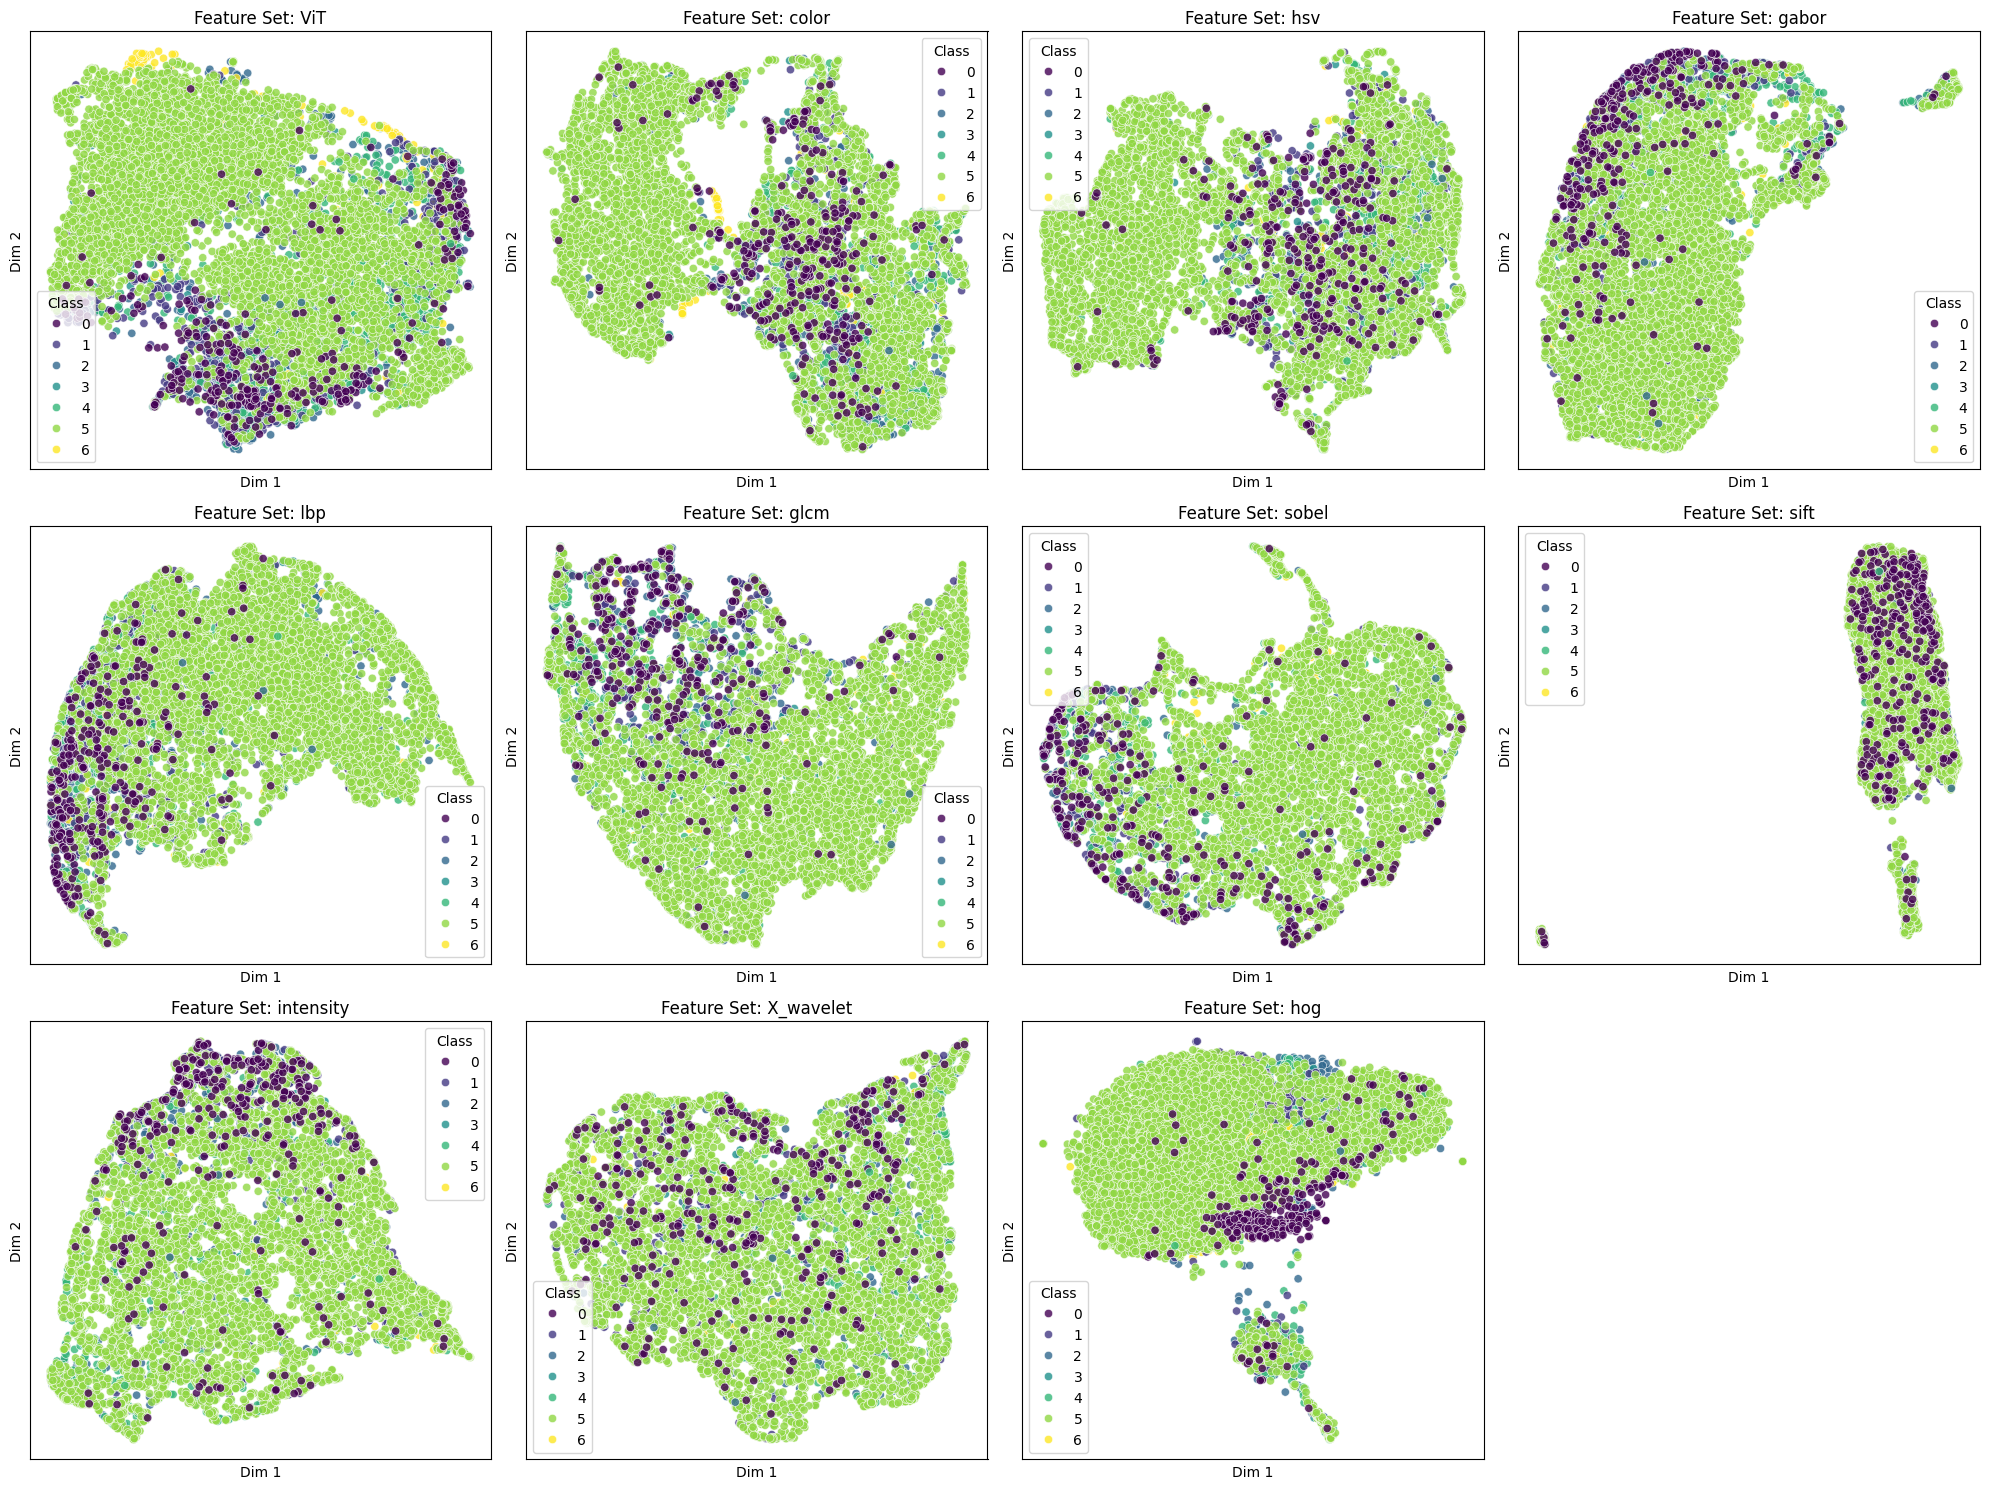

In [ ]:
features_to_visualize = {name: X_feature_sets[name] for name in selected_features_95_variability}
visualize_feature_separability(features_to_visualize, y)

## Execute Pipeline

In [ ]:
# Combine best features
features_to_combine = list(selected_features.values())

# 2. Concatenate all selected feature arrays horizontally (axis=1) using NumPy
# This creates one wide feature matrix.
X_combined = np.concatenate(features_to_combine, axis=1)

print(f"New feature matrix shape: {X_combined.shape}")


New feature matrix shape: (9958, 2368)


In [ ]:
# save the features to skip above cells
feature_filename = "final_combined_features.npz"

print(f"Saving combined features to {feature_filename}...")

# Save the combined feature matrix, the labels, and the class mapping
np.savez_compressed(
    feature_filename,
    X=X_combined,
    y=y,
    label_map=label_encoder.classes_
)

Saving combined features to final_combined_features.npz...


In [7]:
feature_filename = "final_combined_features.npz"
with np.load(feature_filename, allow_pickle=True) as data:
    X_combined = data['X']
    y = data['y']
    label_map = data['label_map']

# Oversampling (F1 Optimization)

In [8]:
rf_results = run_f1_gpu_evaluation_with_per_fold_sampling('RandomForest_GPU', X_combined, y)

--- Starting F1-Optimized Evaluation for: RandomForest_GPU ---
Running Bayesian search (optimizing for F1-score)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits

In [9]:
xgb_results = run_f1_gpu_evaluation_with_per_fold_sampling('XGBoost_GPU', X_combined, y)

--- Starting F1-Optimized Evaluation for: XGBoost_GPU ---
Running Bayesian search (optimizing for F1-score)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitt

In [10]:
KNeighbors_results = run_f1_gpu_evaluation_with_per_fold_sampling('KNeighbors_GPU', X_combined, y)

--- Starting F1-Optimized Evaluation for: KNeighbors_GPU ---
Running Bayesian search (optimizing for F1-score)...
[2025-07-25 01:02:47.811] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[2025-07-25 01:02:47.821] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-07-25 01:02:49.347] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-07-25 01:02:50.095] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-07-25 01:02:50.846] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-07-25 01:02:51.598] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[2025-07-25 01:02:52.359] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initializatio

In [11]:
logreg_results = run_f1_gpu_evaluation_with_per_fold_sampling('LogisticRegression_GPU', X_combined, y)

--- Starting F1-Optimized Evaluation for: LogisticRegression_GPU ---
Running Bayesian search (optimizing for F1-score)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[2025-07-25 01:04:51.236] [CUML] [warning] L-BFGS: max iterations reached
[2025-07-25 01:04:51.237] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-07-25 01:05:07.188] [CUML] [warning] L-BFGS: max iterations reached
[2025-07-25 01:05:07.189] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-07-25 01:05:23.073] [CUML] [warning] L-BFGS: max iterations reached
[2025-07-25 01:05:23.074] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of i

In [ ]:
svc_results = run_f1_gpu_evaluation_with_per_fold_sampling('SVC_GPU_Balanced', X_combined, y)

--- Starting Evaluation for: SVC_GPU_Balanced (using class weights) ---
Running Bayesian search...
[2025-07-24 21:15:13.867] [CUML] [warning] Random state is currently ignored by probabilistic SVC
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[2025-07-24 21:15:13.877] [CUML] [warning] Random state is currently ignored by probabilistic SVC
[2025-07-24 21:15:22.884] [CUML] [warning] Random state is currently ignored by probabilistic SVC
[2025-07-24 21:15:31.236] [CUML] [warning] Random state is currently ignored by probabilistic SVC
[2025-07-24 21:15:39.765] [CUML] [warning] Random state is currently ignored by probabilistic SVC
[2025-07-24 21:15:47.989] [CUML] [warning] Random state is currently ignored by probabilistic SVC
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[2025-07-24 21:15:56.031] [CUML] [warning] Random state is currently ignored by probabilistic SVC
[2025-07-24 21:16:05.106] [CUML] [warning] Random state is currently ignored by probabilistic SVC

In [13]:
all_results = {**rf_results, **xgb_results, **KNeighbors_results, **logreg_results}
all_results

{'RandomForest_GPU': {'best_model': Pipeline(steps=[('sampler',
                   RandomOverSampler(random_state=42,
                                     sampling_strategy='not majority')),
                  ('model', RandomForestClassifier())]),
  'test_set_report':               precision    recall  f1-score      support
  0              0.484848  0.727273  0.581818    66.000000
  1              0.525926  0.689320  0.596639   103.000000
  2              0.456604  0.555046  0.501035   218.000000
  3              0.900000  0.391304  0.545455    23.000000
  4              0.362768  0.684685  0.474259   222.000000
  5              0.930144  0.729730  0.817838  1332.000000
  6              0.947368  0.642857  0.765957    28.000000
  accuracy       0.698293  0.698293  0.698293     0.698293
  macro avg      0.658237  0.631459  0.611857  1992.000000
  weighted avg   0.779328  0.698293  0.721745  1992.000000,
  'test_set_metrics': {'roc_auc_macro': np.float64(0.9347351363500958),
   'accurac

# Class Weighting (F1 Optimization)

In [26]:
rf_f1_weights_results = run_f1_gpu_evaluation_with_class_weights('RandomForest_GPU_Balanced', X_combined, y)

--- Starting Evaluation for: RandomForest_GPU_Balanced (optimizing for f1_macro) ---
Running Bayesian search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Evaluating best model on the hold-out test set...
Best cross-validation F1-macro score: 0.4007
Best hyperparameters: OrderedDict([('max_depth', 33), ('n_bins', 101), ('n_estimators', 212)])
Test Set F1-macro score: 0.4048

Test set classification report:
              precision    recall  f1-score

In [22]:
xgb_f1_weights_results = run_f1_gpu_evaluation_with_class_weights('XGBoost_GPU_Balanced', X_combined, y)

--- Starting Evaluation for: XGBoost_GPU_Balanced (optimizing for f1_macro) ---
Running Bayesian search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Evaluating best model on the hold-out test set...
Best cross-validation F1-macro score: 0.6244
Best hyperparameters: OrderedDict([('learning_rate', 0.1584920130931114), ('max_depth', 5), ('n_estimators', 319)])
Test Set F1-macro score: 0.6887

Test set classification report:
              precision    

In [23]:
KNeighbors_f1_weights_results = run_f1_gpu_evaluation_with_class_weights('KNeighbors_GPU_Balanced', X_combined, y)

--- Starting Evaluation for: KNeighbors_GPU_Balanced (optimizing for f1_macro) ---
Running Bayesian search...
[2025-07-25 02:11:24.179] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[2025-07-25 02:11:24.188] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-07-25 02:11:24.324] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-07-25 02:11:24.458] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-07-25 02:11:24.593] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-07-25 02:11:24.733] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[2025-07-25 02:11:24.873] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2

In [24]:
LogisticRegression_f1_weights_results = run_f1_gpu_evaluation_with_class_weights('LogisticRegression_GPU_Balanced', X_combined, y)

--- Starting Evaluation for: LogisticRegression_GPU_Balanced (optimizing for f1_macro) ---
Running Bayesian search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[2025-07-25 02:11:39.089] [CUML] [warning] L-BFGS: max iterations reached
[2025-07-25 02:11:39.090] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-07-25 02:11:46.516] [CUML] [warning] L-BFGS: max iterations reached
[2025-07-25 02:11:46.516] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-07-25 02:11:53.953] [CUML] [warning] L-BFGS: max iterations reached
[2025-07-25 02:11:53.954] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of itera

# Oversampling (AUC-ROC Optimized)

In [29]:
rf_auc_oversampled_results = run_auc_roc_gpu_evaluation_with_per_fold_sampling('RandomForest_GPU', X_combined, y)

--- Starting Evaluation for: RandomForest_GPU ---
Running Bayesian search (with per-fold CPU-GPU data transfer)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [30]:
xgb_auc_oversampled_results = run_auc_roc_gpu_evaluation_with_per_fold_sampling('XGBoost_GPU', X_combined, y)

--- Starting Evaluation for: XGBoost_GPU ---
Running Bayesian search (with per-fold CPU-GPU data transfer)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitti

In [31]:
KNeighbors_auc_oversampled_results = run_auc_roc_gpu_evaluation_with_per_fold_sampling('KNeighbors_GPU', X_combined, y)

--- Starting Evaluation for: KNeighbors_GPU ---
Running Bayesian search (with per-fold CPU-GPU data transfer)...
[2025-07-25 03:15:15.806] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[2025-07-25 03:15:15.815] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-07-25 03:15:16.375] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-07-25 03:15:16.933] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-07-25 03:15:17.493] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-07-25 03:15:18.051] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[2025-07-25 03:15:18.617] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization

In [32]:
LogisticRegression_auc_oversampled_results = run_auc_roc_gpu_evaluation_with_per_fold_sampling('LogisticRegression_GPU', X_combined, y)

--- Starting Evaluation for: LogisticRegression_GPU ---
Running Bayesian search (with per-fold CPU-GPU data transfer)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[2025-07-25 03:16:51.620] [CUML] [warning] L-BFGS: max iterations reached
[2025-07-25 03:16:51.620] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-07-25 03:17:04.938] [CUML] [warning] L-BFGS: max iterations reached
[2025-07-25 03:17:04.938] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-07-25 03:17:18.213] [CUML] [warning] L-BFGS: max iterations reached
[2025-07-25 03:17:18.214] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of it

# Weighting (AUC-ROC Optimized)

In [33]:
rf_auc_roc_weights_results = run_auc_roc_gpu_evaluation_with_class_weights('RandomForest_GPU_Balanced', X_combined, y)

--- Starting Evaluation for: RandomForest_GPU_Balanced (using class weights) ---
Running Bayesian search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Finding optimal thresholds on validation set...
Optimal thresholds found: [0.18 0.2  0.23 0.08 0.26 0.48 0.11]
Evaluating best model on the hold-out test set with custom thresholds...
Best cross-validation AUC-ROC score: 0.9352
Best hyperparameters: OrderedDict([('max_depth', 23), ('n_bins', 95), ('n_estimators', 470)])
Test Set AUC-ROC score: 0.9504

Test set classification report:
              precision    recall  f1-score      support
0              0.627907  0.409091  0.495413    66.000000
1              0.716418  0.466019  0.564706   103.000000
2              0.604878  0.568807  0.586288   218.000000
3              1.000000  0.173913  0.296296    23.000000
4              0.617834  0.436937  0.511873   222.000000
5              0.845794  0.951201  0.895406  1

In [34]:
xgb_auc_roc_weights_results = run_auc_roc_gpu_evaluation_with_class_weights('XGBoost_GPU_Balanced', X_combined, y)

--- Starting Evaluation for: XGBoost_GPU_Balanced (using class weights) ---
Running Bayesian search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Finding optimal thresholds on validation set...
Optimal thresholds found: [0.31 0.28 0.25 0.09 0.35 0.74 0.48]
Evaluating best model on the hold-out test set with custom thresholds...
Best cross-validation AUC-ROC score: 0.9499
Best hyperparameters: OrderedDict([('learning_rate', 0.17255364529395611), ('max_depth', 14), ('n_estimators', 187)])
Test Set AUC-ROC score: 0.9587

Test set classification report:
              precision    recall  f1-score      support
0              0.578125  0.560606  0.569231    66.000000
1              0.680851  0.621359  0.649746   103.000000
2              0.645320  0.600917  0.622328   218.000000
3              0.769231  0.434783  0.555556    23.000000
4              0.674157  0.540541  0.600000   222.000000
5              0.887245  0.

In [35]:
KNeighbors_auc_roc_weights_results = run_auc_roc_gpu_evaluation_with_class_weights('KNeighbors_GPU_Balanced', X_combined, y)

--- Starting Evaluation for: KNeighbors_GPU_Balanced (using class weights) ---
Running Bayesian search...
[2025-07-25 03:46:07.588] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[2025-07-25 03:46:07.597] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-07-25 03:46:07.700] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-07-25 03:46:07.800] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-07-25 03:46:07.900] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-07-25 03:46:08.002] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[2025-07-25 03:46:08.109] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-

In [36]:
LogisticRegression_auc_roc_weights_results = run_auc_roc_gpu_evaluation_with_class_weights('LogisticRegression_GPU_Balanced', X_combined, y)

--- Starting Evaluation for: LogisticRegression_GPU_Balanced (using class weights) ---
Running Bayesian search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[2025-07-25 03:46:17.104] [CUML] [warning] L-BFGS: max iterations reached
[2025-07-25 03:46:17.105] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-07-25 03:46:24.085] [CUML] [warning] L-BFGS: max iterations reached
[2025-07-25 03:46:24.086] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-07-25 03:46:31.025] [CUML] [warning] L-BFGS: max iterations reached
[2025-07-25 03:46:31.026] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iteration

In [1]:
# Aggregate all results
all_results_f1_oversampled = {**rf_results, **xgb_results, **KNeighbors_results, **logreg_results}
all_results_auc_oversampled = {**rf_auc_oversampled_results, **xgb_auc_oversampled_results, **KNeighbors_auc_oversampled_results, **LogisticRegression_auc_oversampled_results}
all_results_auc_weighted = {**rf_auc_roc_weights_results, **xgb_auc_roc_weights_results, **KNeighbors_auc_roc_weights_results, **LogisticRegression_auc_roc_weights_results}
all_results_f1_weighted = {**rf_f1_weights_results, **xgb_f1_weights_results, **KNeighbors_f1_weights_results, **LogisticRegression_f1_weights_results}

all_results = {
    'F1_Oversampled': all_results_f1_oversampled,
    'AUC_Oversampled': all_results_auc_oversampled,
    'AUC_Weighted': all_results_auc_weighted,
    'F1_Weighted': all_results_f1_weighted
}

# Print the results
print("--- Model Evaluation Results ---")
for strategy, models in all_results.items():
    print(f"\n--- {strategy} ---")
    for model_name, results in models.items():
        print(f"\nModel: {model_name}")
        print(f"Best CV Score: {results.get('best_cv_f1_macro', results.get('best_cv_roc_auc')):.4f}")
        print(f"Test Set AUC-ROC: {results.get('test_set_roc_auc', 'N/A'):.4f}")
        print(f"Test Set F1-macro: {results['test_set_metrics']['f1_macro']:.4f}")
        print(f"Best Params: {results['best_params']}")
        # Optionally print the full report
        # print("\nClassification Report:")
        # display(results['test_set_report'])

NameError: name 'rf_results' is not defined